In [17]:
%matplotlib inline
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import pprint
import operator
import math
import copy
import json
import time

# Utilities

In [45]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
    
# printing result more prettier that 'pprint'!
def print_results(results):
    dumped = json.dumps(results, cls=NumpyEncoder)
    pprint.pprint(json.loads(dumped), width=50)


# visualiser
def draw_config(config, save=False, path=None ,file_name=None, show=True, dpi=100):
    matrix    = config['map']
    lists     = matrix.tolist()
    domains   = config['domains']
    size = len(matrix)

    fig, ax = plt.subplots(figsize=(size, size))
    kwargs = {
        's'          : 1000,
        'c'          : '#bdc3c7',
        'marker'     : "s",
        'alpha'      : 0.5,
    }

    zeros = []
    ones  = []
    nans  = []
    total = []
    
    ax.set_xlim(-1, +1 * size)
    ax.set_ylim(-1, +1 * size)

    
    for row_idx, row in enumerate(lists):
        for col_idx, col in enumerate(row):
            cords = (row_idx, col_idx)
            if np.isnan(matrix[cords]):
                nans.append(cords)
            elif matrix[cords] == 0:
                zeros.append(cords)
            elif matrix[cords] == 1:
                ones.append(cords)
            total.append(cords)
            
    zero_only_domain = []
    one_only_domain = []
    full_domain = []
    
    for cell in nans:
        if len(domains[cell]) == 1 and 1 in domains[cell]:
            one_only_domain.append(cell)
        elif len(domains[cell]) == 1 and 0 in domains[cell]:
            zero_only_domain.append(cell)
        else:
            full_domain.append(cell)
                
    
    kwargs['c'] = '#e74c3c'
    ax.scatter([cord[1] for cord in zero_only_domain], [cord[0] for cord in zero_only_domain], **kwargs)
    
    kwargs['c'] = '#27ae60'
    ax.scatter([cord[1] for cord in one_only_domain], [cord[0] for cord in one_only_domain], **kwargs)
    
    kwargs['c'] = '#b1a467'
    ax.scatter([cord[1] for cord in full_domain], [cord[0] for cord in full_domain], **kwargs)
        

    kwargs['c'] = '#bdc3c7'
    kwargs['marker'] = 's'
    ax.scatter([cord[1] for cord in ones], [cord[0] for cord in ones], **kwargs)
    kwargs['c'] = '#27ae60'
    kwargs['marker'] = '$1$'
    ax.scatter([cord[1] for cord in ones], [cord[0] for cord in ones], **kwargs)

    
    kwargs['c'] = '#bdc3c7'
    kwargs['marker'] = 's'
    ax.scatter([cord[1] for cord in zeros], [cord[0] for cord in zeros], **kwargs)
    kwargs['c'] = '#e74c3c'
    kwargs['marker'] = '$0$'
    ax.scatter([cord[1] for cord in zeros], [cord[0] for cord in zeros], **kwargs)
        

    ax.invert_yaxis()
    if show:
        plt.show()
    if save:
        if not path:
            path = "../default_export_path/"
        Path(path).mkdir(parents=True, exist_ok=True)
        fig.savefig(f'{path}{file_name}', dpi=dpi)
        plt.close(fig)
        
        
# reports results and draw start and final states
def report(configurations, results, initial):
    assert len(results) == len(initial) , 'please provide valied inputs'
    for i in range(len(results)):
        print(f'#problem number {i} ------------------------')
        print(f'@successful: {results[i]["result"]["successful"]}')
        print(f'@elapsed time: {round(results[i]["result"]["time"], 3)} seconds')
        print(f'@start state:')
        s = len(configurations[i]['map'])
        mat = Matrix(s)
        mat.clear_populate(initial[i]['assignment'])
        print('--graphical')
        draw_config({'map': mat.matrix, 'domains': initial[i]['domains']})
        print('--textual')
        pprint.pprint(mat.matrix.tolist()) 
        print('\n')
        
        if results[i]["result"]["successful"]:
            print(f'@result:')
            print('--graphical')
            draw_config({'map': results[i]['result']['final'], 'domains': results[i]['domains']})
            print('--textual')
            print_results(results[i]["result"]["final"])
            print('\n')
            
        else:
            print(f'@result:')
            print('NO solution found...')
            
            
# export each step image to make video from
def export_images(history, output_dir):
    print(f'exporting images in {output_dir}')
    for problem_index, problem_records in enumerate(history):
        print(f'exporting images for problem {problem_index}', end='')
        start = time.time()

        # too many images!
        if len(problem_records) > 9000:
            print(f', too many images [{len(problem_records)}] => aborted')
            continue

        counter = 0
        for index, record in enumerate(problem_records):

            path = f'{output_dir}/{problem_index}/'
            Path(path).mkdir(parents=True, exist_ok=True)
            try:

                size = len(configurations[problem_index]['map'])
                mat = Matrix(size)
                mat.clear_populate(record['assignment'])

                draw_config({'map': mat.matrix, 'domains': record['domains']}, save=True, path=path, 
                            file_name=f'{index + 1:04d}.png', show=False, dpi=70)
                counter += 1
            except Exception as e:
                print(e)

        end = time.time()
        print(f' ,elapsed time: {end - start}, images: {counter}')


def make_animation(frame_rates, base_dir):
    for problem_index, rate in enumerate(frame_rates):
        print(f'making animation for problem {problem_index}')

        input_path = f'../images/{base_dir}/{problem_index}'
        output_path = f'../animations/{base_dir}'
        file_name = f'animation-{problem_index}'

        Path(output_path).mkdir(parents=True, exist_ok=True)
        cmd = ['ffmpeg', '-y', '-framerate', str(rate) , '-i', f'{input_path}/%04d.png', f'{output_path}/{file_name}.mp4']
        process = subprocess.run(cmd, capture_output=True, text=True)

print("done")

done


## Constraints

In [3]:
from typing import Generic, TypeVar, Dict, List, Optional, Tuple
from abc import ABC, abstractmethod

V = TypeVar('V') # variable type
D = TypeVar('D') # domain type

# Base class for all constraints
class Constraint(Generic[V, D], ABC):
    # The variables that the constraint is between
    def __init__(self, variables: List[V]) -> None:
        self.variables = variables

    # Must be overridden by subclasses
    @abstractmethod
    def satisfied(self, assignment: Dict[V, D]) -> bool:
        ...

# In each column or row, the numbers of zeros and ones must be equal
class FirstConstraint(Constraint[Tuple, int]):
    def __init__(self, variables: List[Tuple], problem_size: int) -> None:
        super().__init__(variables)
        self.ps        = problem_size
        self.matrix    = Matrix(problem_size)

    # checks that the assignment satisfies the constraint or not
    # checks for equality of 'sum of each row and column' to 'numbers of cells divided by two'
    def satisfied(self, assignment: Dict[Tuple, int]) -> bool:
        self.matrix.clear_populate(assignment)
        matrix = self.matrix.matrix

        for i in range(0, self.ps):
            if not np.isnan(matrix[i,:]).any():
                if np.sum(matrix[i,:]) != self.ps / 2.0:
                    return False
                
        for i in range(0, self.ps):
            if not np.isnan(matrix[:,i]).any():
                if np.sum(matrix[:,i]) != self.ps / 2.0:
                    return False
        return True
    

# each column an row must be unique
class SecondConstraint(Constraint[Tuple, int]):
    def __init__(self, variables: List[Tuple], problem_size: int) -> None:
        super().__init__(variables)
        self.ps        = problem_size
        self.matrix    = Matrix(problem_size)

    # checks that the assignment satisfies the constraint or not
    # checks for the uniqueness of each row and column in a pair
    def satisfied(self, assignment: Dict[Tuple, int]) -> bool:
        self.matrix.clear_populate(assignment)
        matrix = self.matrix.matrix
        
        for i in range(self.ps):  # generate pairs
            for j in range(i + 1, self.ps):
                if not np.isnan(matrix[i]).any() and np.isnan(matrix[j]).any():
                    if np.array_equal(matrix[i], matrix[j]):  # compare rows
                        return False
                

        for i in range(self.ps):  # generate pairs
            for j in range(i + 1, self.ps): 
                if not np.isnan(matrix[:, i]).any() and np.isnan(matrix[:, j]).any():
                    if np.array_equal(matrix[:,i], matrix[:, j]):  # compare columns
                        return False
        return True

    
# In each column or row, there must not be more than two equal numbers(zero or one)
class ThirdConstraint(Constraint[Tuple, int]):
    def __init__(self, variables: List[Tuple], problem_size: int) -> None:
        super().__init__(variables)
        self.ps        = problem_size
        self.matrix    = Matrix(problem_size)
        
    # checks that the assignment satisfies the constraint or not
    # checks for the triple similarity for each variable in the assignment
    def satisfied(self, assignment: Dict[Tuple, int]) -> bool:
        self.matrix.clear_populate(assignment)
        matrix = self.matrix

        for var in assignment:
            if matrix.left(var) == matrix.matrix[var] == matrix.right(var):
                return False
            
            if matrix.up(var) == matrix.matrix[var] == matrix.down(var):
                return False
        return True

## CSP and solvers implementation

In [75]:
# A helper class for this specific problem to make calculations easier
# used for representing of each state (via a matrix)
class Matrix():
    def __init__(self, size:int) -> None:
        self.matrix = np.empty((size, size))
        self.matrix[:] = np.nan
        self.size = size
        
    def clear_populate(self, assignment: Dict[V, D]) -> None:
        self.matrix[:] = np.nan
        for variable in assignment:
            self.matrix[variable] = assignment[variable]
            
    def up(self, variable: V) -> V:
        if variable[0] == 0:
            return None
        else:
            new_variable = tuple(map(operator.add, variable, (-1,  0)))
            return self.matrix[new_variable]
        
    def down(self, variable: V) -> V:
        if variable[0] == self.size - 1:
            return None
        else:
            new_variable = tuple(map(operator.add, variable, (+1,  0)))
            return self.matrix[new_variable]
    
    def left(self, variable: V) -> V:
        if variable[1] == 0:
            return None
        else:
            new_variable = tuple(map(operator.add, variable, ( 0, -1)))
            return self.matrix[new_variable]
        
    def right(self, variable: V) -> V:
        if variable[1] == self.size - 1:
            return None
        else:
            new_variable = tuple(map(operator.add, variable, ( 0, +1)))
            return self.matrix[new_variable]
        
    def not_populated_adjacents(self, variable: V) -> List[V]:
        
        s = self.size - 1
        left_var  = tuple(map(operator.add, variable, ( 0, -1))) if variable[1] > 0 else None
        right_var = tuple(map(operator.add, variable, ( 0, +1))) if variable[1] < s else None
        down_var  = tuple(map(operator.add, variable, (+1,  0))) if variable[0] < s else None
        up_var    = tuple(map(operator.add, variable, (-1,  0))) if variable[0] > 0 else None
        
        result = []
        if left_var  is not None and np.isnan(self.matrix[left_var ]): result.append(left_var)
        if right_var is not None and np.isnan(self.matrix[right_var]): result.append(right_var)
        if down_var  is not None and np.isnan(self.matrix[down_var ]): result.append(down_var)
        if up_var    is not None and np.isnan(self.matrix[up_var   ]): result.append(up_var)
        
        return result
    
    def adjacents(self, variable: V) -> List[V]:
            
        s = self.size - 1
        left_var  = tuple(map(operator.add, variable, ( 0, -1))) if variable[1] > 0 else None
        right_var = tuple(map(operator.add, variable, ( 0, +1))) if variable[1] < s else None
        down_var  = tuple(map(operator.add, variable, (+1,  0))) if variable[0] < s else None
        up_var    = tuple(map(operator.add, variable, (-1,  0))) if variable[0] > 0 else None
        
        result = []
        if left_var  is not None: result.append(left_var)
        if right_var is not None: result.append(right_var)
        if down_var  is not None: result.append(down_var)
        if up_var    is not None: result.append(up_var)
        
        return result
        

# A constraint satisfaction problem consists of variables of type V
# that have ranges of values known as domains of type D and constraints
# that determine whether a particular variable's domain selection is valid
class CSP(Generic[V, D]):
    def __init__(self, variables: List[V], domains: Dict[V, List[D]]) -> None:
        self.variables:    List[V]                         = variables # variables to be constrained
        self.domains:      Dict[V, List[D]]                = domains   # domain of each variable
        self.constraints:  Dict[V, List[Constraint[V, D]]] = {}        # constraints of each variable
        self.problem_size: int                             = int(math.sqrt(len(variables)))
        self.matrix:       Matrix                          = Matrix(self.problem_size)
        assert math.isqrt(len(variables)) , "please provide valid size of variables"
        
        # these lists are for visualizing and do not participate in solving procedure
        self.backtracking_history     = []
        self.backtracking_FC_history  = []
        self.backtracking_MAC_history = []
            
        # in start each variable has an empty list of constraints
        for variable in self.variables:
            self.constraints[variable] = []
            if variable not in self.domains:
                raise LookupError("Every variable should have a domain assigned to it.")

                
    # Adding constraint to CSP problem
    # each constraint has a list target varibles, 
    # we using that for assign 'the constraint' to each variable in that list
    def add_constraint(self, constraint: Constraint[V, D]) -> None:
        for variable in constraint.variables:
            if variable not in self.variables:
                raise LookupError("Variable in constraint not in CSP")
            else:
                self.constraints[variable].append(constraint)

                
    # Check if the value assignment is consistent by checking all constraints
    # for the given variable against it
    def consistent(self, variable: V, assignment: Dict[V, D]) -> bool:
        for constraint in self.constraints[variable]:
            if not constraint.satisfied(assignment):
                return False
        return True
    
    
    # Does 'Forward Checking' for values in 'domains' for adjacents of 'variable' in 'assignment'
    def forward_checking(self, domains: Dict[V, List[D]], assignment: Dict[V, D], variable: Tuple) -> Dict[V, List[D]]:
    
        # the representaion of assignmetns in form of a matirx
        # clearing the previous matrix and fill it with new assignments
        self.matrix.clear_populate(assignment)
        matrix = self.matrix # get rid of 'self'
        
        new_domains = copy.deepcopy(domains)
        queue = matrix.not_populated_adjacents(variable)        
        
        for adj in queue:
            bad_values_in_domain = []
            for value in new_domains[adj]:
                assignment[adj] = value
                if not self.consistent(adj, assignment):
                    bad_values_in_domain.append(value)
                
                del assignment[adj]
                
            new_values_in_domain = [d for d in new_domains[adj] if d not in bad_values_in_domain]
            if not new_values_in_domain:
                return None
            
            new_domains[adj] = new_values_in_domain
        return new_domains
    
    
    # make variable1 arc consistent with respect to variable2        
    # this method changes domains
    def arc_consistent(self, variable1: V, variable2: V, domains: Dict[V, List[D]], assignment: Dict[V, D]) -> bool:
        removed = False
        for var1_value in domains[variable1]:
            fake_assignment = copy.deepcopy(assignment)
            fake_assignment[variable1] = var1_value
            
            found_indefectible_value = False
            for var2_value in domains[variable2]:
                fake_assignment[variable2] = var2_value
                if self.consistent(variable2, fake_assignment):
                    found_indefectible_value = True
                    break
            
            del fake_assignment[variable2]
            if not found_indefectible_value:
                domains[variable1].remove(var1_value)
                removed = True 
        return removed
            
    
    # Gives a queue of paired arcs and makes the first arc arc_consistent to the second arc
    # and considers cascading changes to domains
    def AC_3(self, queue: List[Tuple], domains: Dict[V, List[D]], assignment: Dict[V, D]) -> bool:
        
        # the representaion of assignmetns in form of a matirx
        # clearing the previous matrix and fill it with new assignments
        self.matrix.clear_populate(assignment)
        matrix = self.matrix # get rid of 'self'
        
        while len(queue) > 0:
            pair = queue.pop(0)
            var1 = pair[0] # adj
            var2 = pair[1] # var
            domain_changed = self.arc_consistent(var1, var2, domains, assignment)
            if not domain_changed:
                continue
            if len(domains[var1]) == 0:
                return False
            
            adjacents = matrix.adjacents(var1)
            adjacents.remove(var2)
            
            for adj in adjacents:
                queue.append((adj, var1))
                
        return True
            
        
    # MAC algorithm
    def MAC(self, domains: Dict[V, List[D]], assignment: Dict[V, D], variable: Tuple) -> bool:
        
        # the representaion of assignmetns in form of a matirx
        # clearing the previous matrix and fill it with new assignments
        self.matrix.clear_populate(assignment)
        matrix = self.matrix # get rid of 'self'
        
        new_domains = copy.deepcopy(domains)
        adjacents = matrix.not_populated_adjacents(variable)
        queue = [(adj, variable) for adj in adjacents]
        
        if self.AC_3(queue, new_domains, assignment):
            return new_domains
        else:
            return None
    
    
    # Minimum Remaining Values
    def MRV(self, domain: List[D]) -> int:
        return len(domain)
    
    
    # Solver
    # using backtrack algorithm with MRV
    def backtracking_search(self, assignment: Dict[V, D] = {}) -> Optional[Dict[V, D]]:\
        
        # return condition
        # assignment is complete if every variable is assigned (our base case)
        if len(assignment) == len(self.variables):
            return assignment
        
        # select a variable for assigning a value to it
        unassigned: List[V] = [v for v in self.variables if v not in assignment]
        unassigned.sort(key=lambda v: (self.MRV(self.domains[v]))) # MRV
        first: V = unassigned[0]
            
        # select a value from domain of variable    
        for value in self.domains[first]:
            local_assignment = assignment.copy()
            local_assignment[first] = value
            
            # recording this assignment and domains for visualization
            self.backtracking_history.append({
                'assignment': copy.deepcopy(local_assignment),
                'domains': copy.deepcopy(domains),
            })
            
            if self.consistent(first, local_assignment): # there is no problem with this assignment
                result: Optional[Dict[V, D]] = self.backtracking_search(local_assignment)
                # if we're still consistent, we continue
                if result is not None:
                    return result
                
        return None
    
   
    # Solver
    # using backtrack algorithm with FC and MRV
    def backtracking_search_with_FC(self, assignment: Dict[V, D], domains: Dict[V, List[D]]) -> Optional[Dict[V, D]]:
        
        # return condition
        # assignment is complete if every variable is assigned (our base case)
        if len(assignment) == len(self.variables):
            return assignment

        # select a variable for assigning a value to it
        unassigned: List[V] = [v for v in self.variables if v not in assignment]
        unassigned.sort(key=lambda v: (self.MRV(domains[v])))  
        first: V = unassigned[0]
            
        # select a value from domain of variable    
        for value in domains[first]:
            local_assignment = assignment.copy()
            local_assignment[first] = value
            
            # forward checking 
            new_domains = self.forward_checking(domains, local_assignment, first)
            if not new_domains:
                continue
                
            # recording this assignment and domains for visualization
            self.backtracking_FC_history.append({
                'assignment': copy.deepcopy(local_assignment),
                'domains': copy.deepcopy(new_domains),
            })
            
            result: Optional[Dict[V, D]] = self.backtracking_search_with_FC(local_assignment, new_domains)
            if result is not None:
                return result
            
        return None
    
    
    # Solver
    # using backtrack algorithm with MAC and MRV
    def backtracking_search_with_MAC(self, assignment: Dict[V, D], domains: Dict[V, List[D]]) -> Optional[Dict[V, D]]:
        
        # return condition
        # assignment is complete if every variable is assigned (our base case)
        if len(assignment) == len(self.variables):
            return assignment

        # select a variable for assigning a value to it
        unassigned: List[V] = [v for v in self.variables if v not in assignment]
        unassigned.sort(key=lambda v: (self.MRV(domains[v])))
        first: V = unassigned[0]
            
        # select a value from domain of variable
        for value in domains[first]:
            local_assignment = assignment.copy()
            local_assignment[first] = value
            local_domains = copy.deepcopy(domains)
            local_domains[first] = [value]
            
            # MAC
            new_domains = self.MAC(local_domains, local_assignment, first)
            if not new_domains:
                continue

            # recording this assignment and domains for visualization
            self.backtracking_MAC_history.append({
                'assignment': copy.deepcopy(local_assignment),
                'domains': copy.deepcopy(new_domains),
            }) 
            
            result: Optional[Dict[V, D]] = self.backtracking_search_with_MAC(local_assignment, new_domains)
            if result is not None:
                return result
            
        return None

## importing problems and initializing configurations



** A little hint: the yellowish color of the cell means it can be filled with either 0 or 1
**                the green     color of the cell means it can be filled only with 1
**                the red       color of the cell means it can be filled only with 0
**                some cells are already filled with 0 or 1


Problem number 0 --------------------------------
array([[ 1.,  0., nan, nan],
       [ 0., nan, nan,  1.],
       [nan,  0., nan,  1.],
       [nan,  1.,  1., nan]])


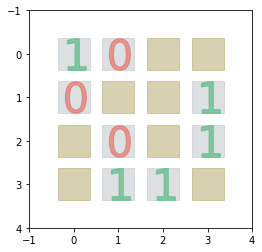

Problem number 1 --------------------------------
array([[ 1., nan, nan, nan, nan, nan],
       [nan,  0.,  1.,  0., nan, nan],
       [nan, nan, nan,  0., nan,  0.],
       [nan,  0., nan, nan, nan, nan],
       [nan,  1.,  0., nan, nan, nan],
       [ 0., nan,  0., nan,  1., nan]])


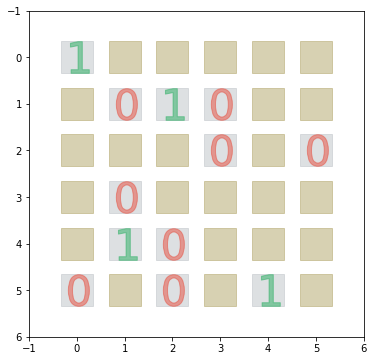

Problem number 2 --------------------------------
array([[nan, nan,  1., nan, nan,  1.],
       [nan, nan, nan,  1.,  1.,  0.],
       [nan, nan,  0., nan,  0., nan],
       [ 0., nan, nan, nan,  0., nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan,  1.]])


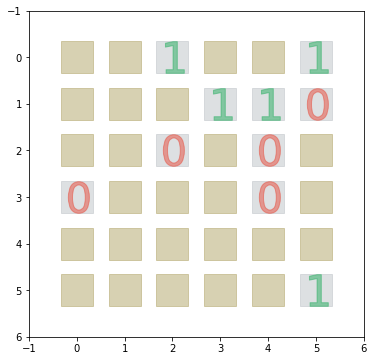

Problem number 3 --------------------------------
array([[nan, nan, nan,  0.,  0., nan, nan, nan],
       [ 0., nan,  1.,  0., nan,  0., nan,  1.],
       [nan,  1.,  0.,  1., nan, nan, nan, nan],
       [nan,  1., nan, nan, nan, nan, nan, nan],
       [nan, nan, nan,  1., nan,  0., nan,  0.],
       [ 1., nan, nan,  0., nan, nan,  1., nan],
       [nan, nan,  0., nan,  0.,  1., nan, nan],
       [nan,  0., nan, nan, nan,  0., nan, nan]])


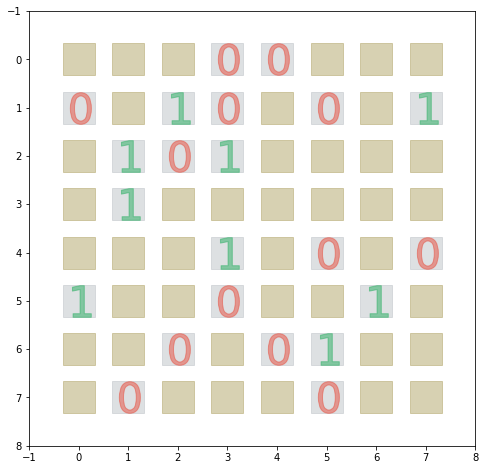

Problem number 4 --------------------------------
array([[nan,  0., nan, nan, nan, nan, nan, nan, nan, nan],
       [nan,  0., nan, nan, nan, nan, nan,  1., nan,  0.],
       [ 1., nan, nan, nan,  1.,  0., nan, nan, nan, nan],
       [nan, nan, nan,  0., nan, nan, nan, nan, nan,  1.],
       [nan, nan, nan, nan,  1., nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan,  1.,  1., nan, nan],
       [nan,  1., nan,  1., nan, nan,  1., nan, nan, nan],
       [ 0., nan, nan, nan, nan, nan, nan, nan,  0., nan],
       [nan,  1., nan, nan,  1., nan, nan,  1.,  0., nan],
       [nan, nan, nan,  0., nan,  0., nan, nan, nan, nan]])


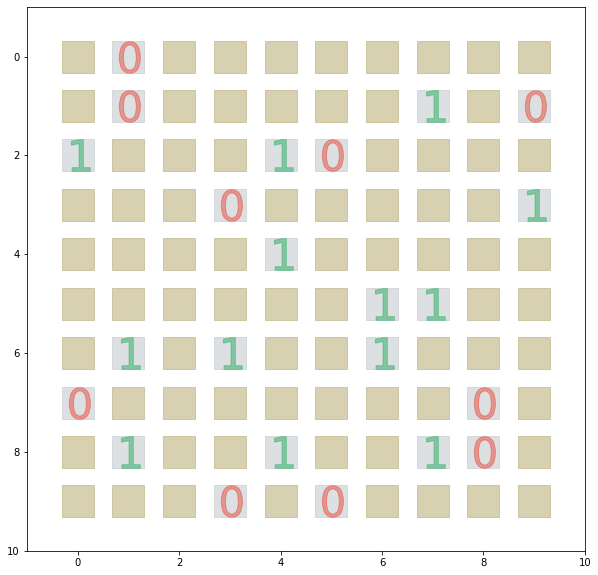

Problem number 5 --------------------------------
array([[nan,  1., nan, nan, nan,  1., nan, nan, nan, nan],
       [nan, nan, nan, nan,  0.,  0., nan, nan, nan, nan],
       [nan, nan,  1., nan, nan, nan, nan,  1., nan, nan],
       [nan, nan, nan, nan, nan,  1., nan, nan,  0., nan],
       [ 0., nan,  0., nan, nan, nan, nan,  1., nan, nan],
       [ 1.,  0., nan, nan,  1., nan, nan,  1., nan,  1.],
       [nan,  0., nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan,  1.,  1., nan, nan, nan,  1.],
       [nan,  0., nan,  0.,  1., nan, nan, nan, nan, nan],
       [ 1.,  1., nan, nan, nan, nan,  0., nan,  0.,  1.]])


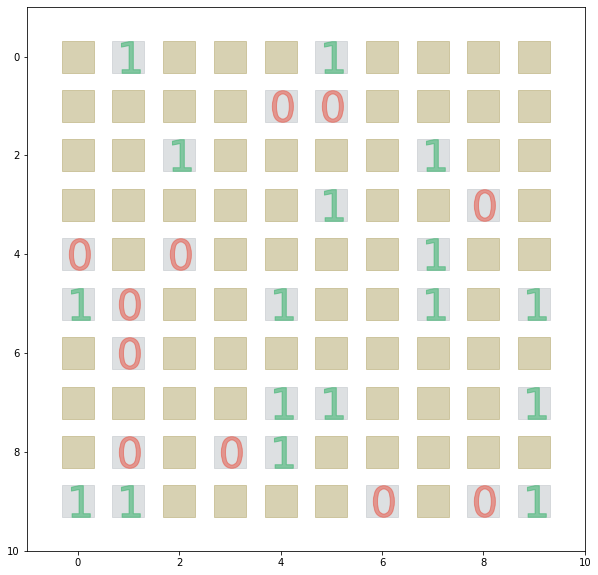

In [5]:
input_files = [
    '../puzzles/puzzle0.txt',
    '../puzzles/puzzle1.txt',
    '../puzzles/puzzle2.txt',
    '../puzzles/puzzle3.txt',
    '../puzzles/puzzle4.txt',
    '../puzzles/puzzle5.txt',
]

configurations = []

# initializing 'map' for each config
for index, f in enumerate(input_files):
    configuration = {}
    with open(f, 'r') as file:
        lines = file.readlines()
        lines = [line.strip() for line in lines]
        
        first_line = lines.pop(0)
        row, col = first_line.split(' ')        
        
        row, col = int(row), int(col)
        initial_map = np.empty((row, col))
        initial_map[:] = np.nan
        for i, line in enumerate(lines):
            temp = line.split(' ')
            for j, element in enumerate(temp):
                if element =='1':
                    initial_map[(i, j)] = 1
                elif element == '0':
                    initial_map[(i, j)] = 0
                else:
                    pass
        configuration['map'] = initial_map
    configurations.append(configuration)
    
# initializing 'domains', 'variables', 'asssignment' for each config
for config in configurations:
    initial_map = config['map']
    size = len(initial_map)
    r = range(0, size)
    
    assignment = {}
    domains = {}
    for i in r:
        for j in r:
            variable = (i, j)

            if initial_map[variable] == 1:
                assignment[variable] = 1
                domains[variable] = [1]

            elif initial_map[variable] == 0:
                assignment[variable] = 0
                domains[variable] = [0]

            else:
                domains[variable] = [0, 1]

    config['domains']    = domains
    config['variables']  = domains.keys()
    config['assignment'] = assignment

# showing results
print('\n')
print('** A little hint: the yellowish color of the cell means it can be filled with either 0 or 1')
print('**                the green     color of the cell means it can be filled only with 1')
print('**                the red       color of the cell means it can be filled only with 0')
print('**                some cells are already filled with 0 or 1\n\n')

for index, config in enumerate(configurations):
    print(f"Problem number {index} --------------------------------")
    pprint.pprint(config['map'])
    draw_config(config)

In [6]:
initial_ = [] # after first updating domains
results_ = [] # final results
history_ = [] # history of each assignment in solving procedure
for index, config in enumerate(configurations):

    result = {}
    domains:    Dict[Tuple, List[int]] = config['domains']
    variables:  List[Tuple]            = config['variables']
    assignment: Dict[Tuple, int]       = config['assignment']
        
    s = len(config['map'])
    
    csp: CSP[Tuple, int] = CSP(variables, domains)
    csp.add_constraint(FirstConstraint(variables, s))
    csp.add_constraint(SecondConstraint(variables, s))
    csp.add_constraint(ThirdConstraint(variables, s))

    start = time.time()
    initial_.append({
        'assignment': copy.deepcopy(assignment),
        'domains': copy.deepcopy(domains),
    })
    solution: Optional[Dict[Tuple, int]] = csp.backtracking_search(assignment=assignment)
    end = time.time()
    
    history_.append(copy.deepcopy(csp.backtracking_history))
    if solution is None:
        print("No solution found!")
        result['final']      = None
        result['time']       = end - start
        result['successful'] = False
    else:
        print(f'elapsed time for problem {index}: {round(end - start, 5)}')
        mat = Matrix(s)
        mat.clear_populate(solution)
        m = mat.matrix
        
        assert np.where(np.isnan(m) == True)[0].size == 0 , "find np.nan in result!"
        assert np.where(np.isnan(m) == True)[1].size == 0 , "find np.nan in result!"

        result['final']      = m.astype(np.int8, copy=False)
        result['time']       = end - start
        result['successful'] = True
    
    results_.append({
        'result': result,
        'domains': csp.domains
    })
    if index == 4: # we know last one doesnt have answer (consumes lots of memory)
        break

elapsed time for problem 0: 0.006
elapsed time for problem 1: 0.096
elapsed time for problem 2: 0.109
elapsed time for problem 3: 0.23106
elapsed time for problem 4: 221.52987


#problem number 0 ------------------------
@successful: True
@elapsed time: 0.006 seconds
@start state:
--graphical


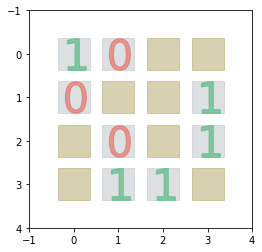

--textual
[[1.0, 0.0, nan, nan],
 [0.0, nan, nan, 1.0],
 [nan, 0.0, nan, 1.0],
 [nan, 1.0, 1.0, nan]]


@result:
--graphical


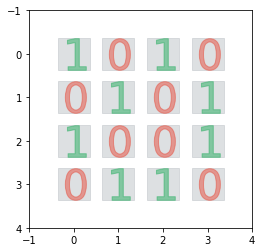

--textual
[[1, 0, 1, 0],
 [0, 1, 0, 1],
 [1, 0, 0, 1],
 [0, 1, 1, 0]]


#problem number 1 ------------------------
@successful: True
@elapsed time: 0.096 seconds
@start state:
--graphical


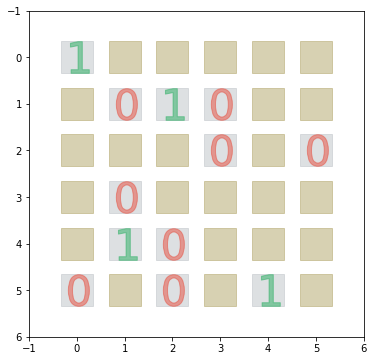

--textual
[[1.0, nan, nan, nan, nan, nan],
 [nan, 0.0, 1.0, 0.0, nan, nan],
 [nan, nan, nan, 0.0, nan, 0.0],
 [nan, 0.0, nan, nan, nan, nan],
 [nan, 1.0, 0.0, nan, nan, nan],
 [0.0, nan, 0.0, nan, 1.0, nan]]


@result:
--graphical


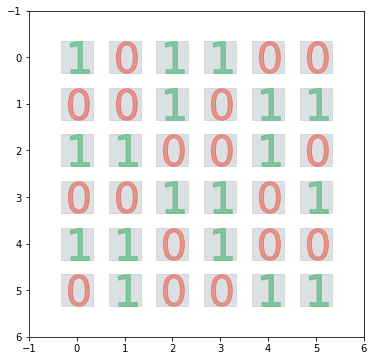

--textual
[[1, 0, 1, 1, 0, 0],
 [0, 0, 1, 0, 1, 1],
 [1, 1, 0, 0, 1, 0],
 [0, 0, 1, 1, 0, 1],
 [1, 1, 0, 1, 0, 0],
 [0, 1, 0, 0, 1, 1]]


#problem number 2 ------------------------
@successful: True
@elapsed time: 0.109 seconds
@start state:
--graphical


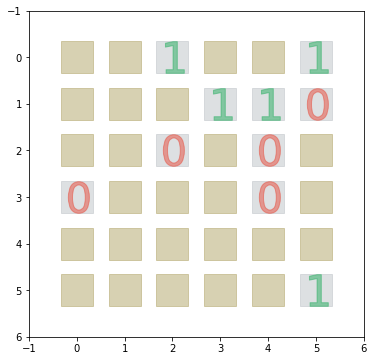

--textual
[[nan, nan, 1.0, nan, nan, 1.0],
 [nan, nan, nan, 1.0, 1.0, 0.0],
 [nan, nan, 0.0, nan, 0.0, nan],
 [0.0, nan, nan, nan, 0.0, nan],
 [nan, nan, nan, nan, nan, nan],
 [nan, nan, nan, nan, nan, 1.0]]


@result:
--graphical


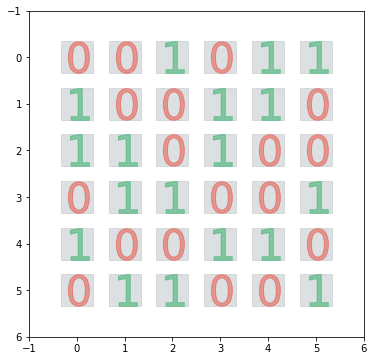

--textual
[[0, 0, 1, 0, 1, 1],
 [1, 0, 0, 1, 1, 0],
 [1, 1, 0, 1, 0, 0],
 [0, 1, 1, 0, 0, 1],
 [1, 0, 0, 1, 1, 0],
 [0, 1, 1, 0, 0, 1]]


#problem number 3 ------------------------
@successful: True
@elapsed time: 0.231 seconds
@start state:
--graphical


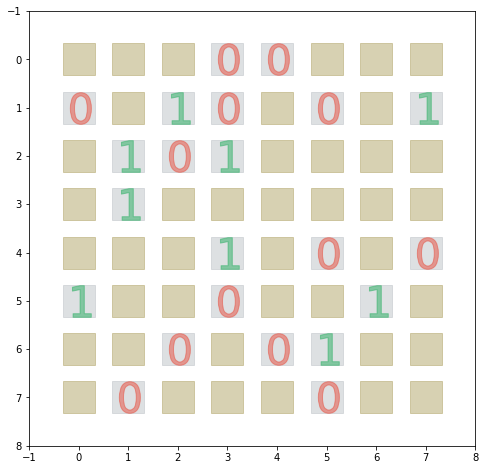

--textual
[[nan, nan, nan, 0.0, 0.0, nan, nan, nan],
 [0.0, nan, 1.0, 0.0, nan, 0.0, nan, 1.0],
 [nan, 1.0, 0.0, 1.0, nan, nan, nan, nan],
 [nan, 1.0, nan, nan, nan, nan, nan, nan],
 [nan, nan, nan, 1.0, nan, 0.0, nan, 0.0],
 [1.0, nan, nan, 0.0, nan, nan, 1.0, nan],
 [nan, nan, 0.0, nan, 0.0, 1.0, nan, nan],
 [nan, 0.0, nan, nan, nan, 0.0, nan, nan]]


@result:
--graphical


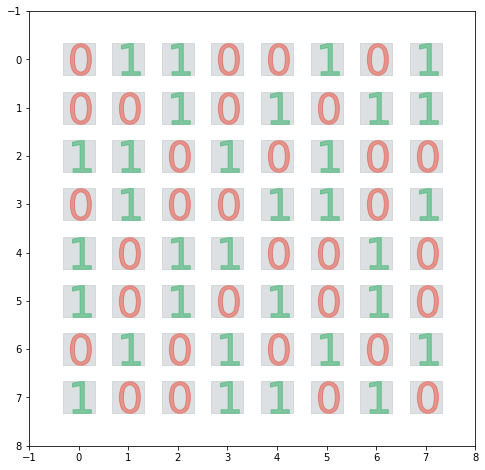

--textual
[[0, 1, 1, 0, 0, 1, 0, 1],
 [0, 0, 1, 0, 1, 0, 1, 1],
 [1, 1, 0, 1, 0, 1, 0, 0],
 [0, 1, 0, 0, 1, 1, 0, 1],
 [1, 0, 1, 1, 0, 0, 1, 0],
 [1, 0, 1, 0, 1, 0, 1, 0],
 [0, 1, 0, 1, 0, 1, 0, 1],
 [1, 0, 0, 1, 1, 0, 1, 0]]


#problem number 4 ------------------------
@successful: True
@elapsed time: 221.53 seconds
@start state:
--graphical


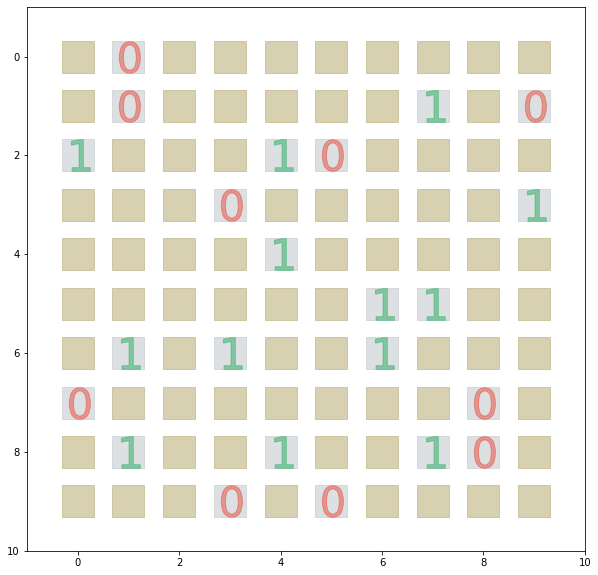

--textual
[[nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan],
 [nan, 0.0, nan, nan, nan, nan, nan, 1.0, nan, 0.0],
 [1.0, nan, nan, nan, 1.0, 0.0, nan, nan, nan, nan],
 [nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 1.0],
 [nan, nan, nan, nan, 1.0, nan, nan, nan, nan, nan],
 [nan, nan, nan, nan, nan, nan, 1.0, 1.0, nan, nan],
 [nan, 1.0, nan, 1.0, nan, nan, 1.0, nan, nan, nan],
 [0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, nan],
 [nan, 1.0, nan, nan, 1.0, nan, nan, 1.0, 0.0, nan],
 [nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan]]


@result:
--graphical


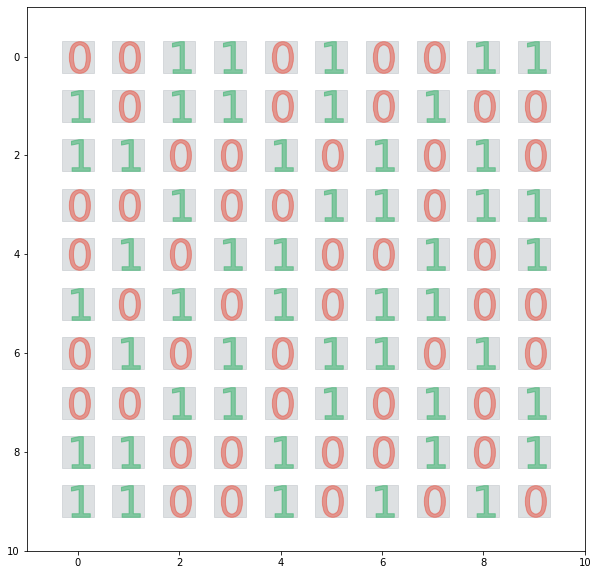

--textual
[[0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
 [1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
 [1, 1, 0, 0, 1, 0, 1, 0, 1, 0],
 [0, 0, 1, 0, 0, 1, 1, 0, 1, 1],
 [0, 1, 0, 1, 1, 0, 0, 1, 0, 1],
 [1, 0, 1, 0, 1, 0, 1, 1, 0, 0],
 [0, 1, 0, 1, 0, 1, 1, 0, 1, 0],
 [0, 0, 1, 1, 0, 1, 0, 1, 0, 1],
 [1, 1, 0, 0, 1, 0, 0, 1, 0, 1],
 [1, 1, 0, 0, 1, 0, 1, 0, 1, 0]]




In [7]:
report(configurations, results_, initial_)

In [8]:
initial_FC = [] # after first updating domains
results_FC = [] # final results
history_FC = [] # history of each assignment in solving procedure
for index, config in enumerate(configurations):

    result = {}
    domains:    Dict[Tuple, List[int]] = config['domains']
    variables:  List[Tuple]            = config['variables']
    assignment: Dict[Tuple, int]       = config['assignment']
        
    s = len(config['map'])
    
    csp: CSP[Tuple, int] = CSP(variables, domains)
    csp.add_constraint(FirstConstraint(variables, s))
    csp.add_constraint(SecondConstraint(variables, s))
    csp.add_constraint(ThirdConstraint(variables, s))

    start = time.time()
    for a in assignment:
        domains = csp.forward_checking(domains, assignment, a)
    
    initial_FC.append({
        'assignment': copy.deepcopy(assignment),
        'domains': copy.deepcopy(domains),
    })
    
    solution: Optional[Dict[Tuple, int]] = csp.backtracking_search_with_FC(assignment=assignment, domains=domains)
    end = time.time()
    
    history_FC.append(copy.deepcopy(csp.backtracking_FC_history))

    if solution is None:
        print("No solution found!")
        result['final']      = None
        result['time']       = end - start
        result['successful'] = False
    else:
        print(f'elapsed time for problem {index}: {round(end - start, 5)}')
        mat = Matrix(s)
        mat.clear_populate(solution)
        m = mat.matrix
        
        assert np.where(np.isnan(m) == True)[0].size == 0 , "find np.nan in result!"
        assert np.where(np.isnan(m) == True)[1].size == 0 , "find np.nan in result!"

        result['final']      = m.astype(np.int8, copy=False)
        result['time']       = end - start
        result['successful'] = True
    
    results_FC.append({
        'result': result,
        'domains': csp.domains
    })

elapsed time for problem 0: 0.00609
elapsed time for problem 1: 0.04002
elapsed time for problem 2: 0.05698
elapsed time for problem 3: 0.20303
elapsed time for problem 4: 29.06454
No solution found!


#problem number 0 ------------------------
@successful: True
@elapsed time: 0.006 seconds
@start state:
--graphical


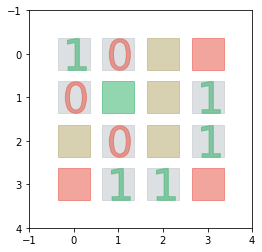

--textual
[[1.0, 0.0, nan, nan],
 [0.0, nan, nan, 1.0],
 [nan, 0.0, nan, 1.0],
 [nan, 1.0, 1.0, nan]]


@result:
--graphical


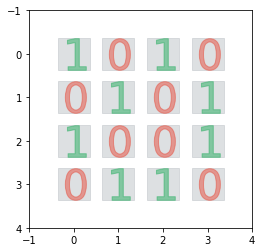

--textual
[[1, 0, 1, 0],
 [0, 1, 0, 1],
 [1, 0, 0, 1],
 [0, 1, 1, 0]]


#problem number 1 ------------------------
@successful: True
@elapsed time: 0.04 seconds
@start state:
--graphical


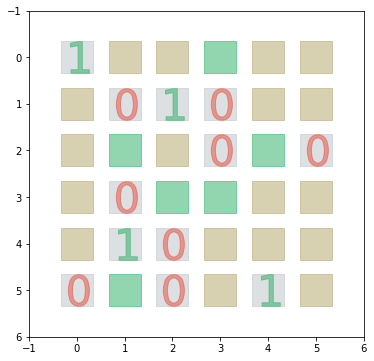

--textual
[[1.0, nan, nan, nan, nan, nan],
 [nan, 0.0, 1.0, 0.0, nan, nan],
 [nan, nan, nan, 0.0, nan, 0.0],
 [nan, 0.0, nan, nan, nan, nan],
 [nan, 1.0, 0.0, nan, nan, nan],
 [0.0, nan, 0.0, nan, 1.0, nan]]


@result:
--graphical


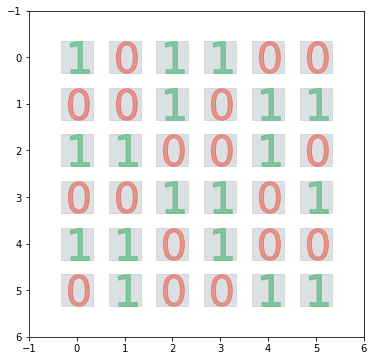

--textual
[[1, 0, 1, 1, 0, 0],
 [0, 0, 1, 0, 1, 1],
 [1, 1, 0, 0, 1, 0],
 [0, 0, 1, 1, 0, 1],
 [1, 1, 0, 1, 0, 0],
 [0, 1, 0, 0, 1, 1]]


#problem number 2 ------------------------
@successful: True
@elapsed time: 0.057 seconds
@start state:
--graphical


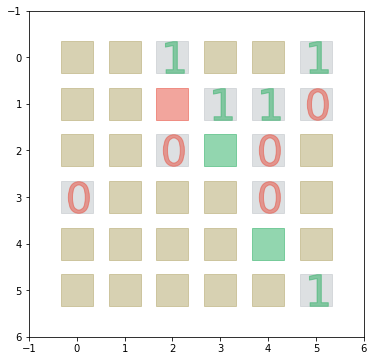

--textual
[[nan, nan, 1.0, nan, nan, 1.0],
 [nan, nan, nan, 1.0, 1.0, 0.0],
 [nan, nan, 0.0, nan, 0.0, nan],
 [0.0, nan, nan, nan, 0.0, nan],
 [nan, nan, nan, nan, nan, nan],
 [nan, nan, nan, nan, nan, 1.0]]


@result:
--graphical


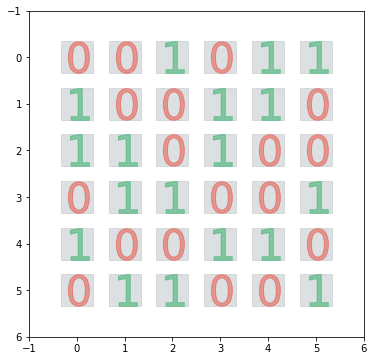

--textual
[[0, 0, 1, 0, 1, 1],
 [1, 0, 0, 1, 1, 0],
 [1, 1, 0, 1, 0, 0],
 [0, 1, 1, 0, 0, 1],
 [1, 0, 0, 1, 1, 0],
 [0, 1, 1, 0, 0, 1]]


#problem number 3 ------------------------
@successful: True
@elapsed time: 0.203 seconds
@start state:
--graphical


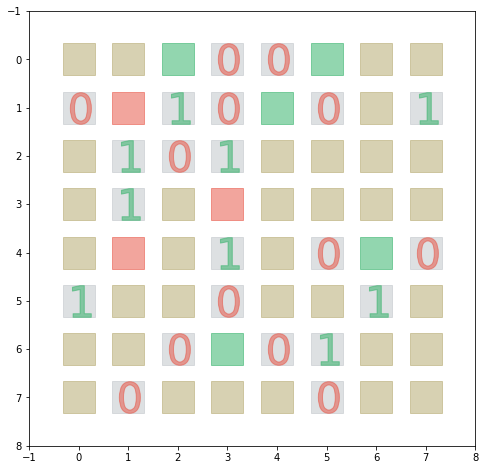

--textual
[[nan, nan, nan, 0.0, 0.0, nan, nan, nan],
 [0.0, nan, 1.0, 0.0, nan, 0.0, nan, 1.0],
 [nan, 1.0, 0.0, 1.0, nan, nan, nan, nan],
 [nan, 1.0, nan, nan, nan, nan, nan, nan],
 [nan, nan, nan, 1.0, nan, 0.0, nan, 0.0],
 [1.0, nan, nan, 0.0, nan, nan, 1.0, nan],
 [nan, nan, 0.0, nan, 0.0, 1.0, nan, nan],
 [nan, 0.0, nan, nan, nan, 0.0, nan, nan]]


@result:
--graphical


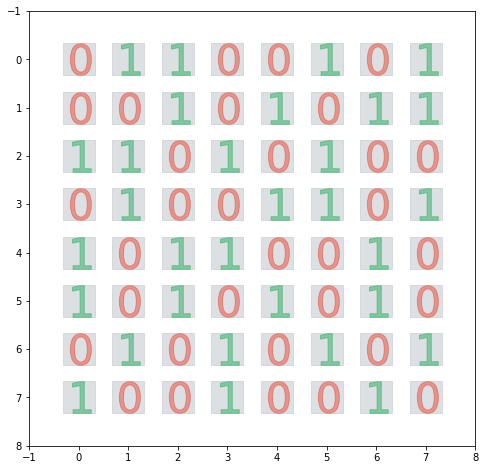

--textual
[[0, 1, 1, 0, 0, 1, 0, 1],
 [0, 0, 1, 0, 1, 0, 1, 1],
 [1, 1, 0, 1, 0, 1, 0, 0],
 [0, 1, 0, 0, 1, 1, 0, 1],
 [1, 0, 1, 1, 0, 0, 1, 0],
 [1, 0, 1, 0, 1, 0, 1, 0],
 [0, 1, 0, 1, 0, 1, 0, 1],
 [1, 0, 0, 1, 0, 0, 1, 0]]


#problem number 4 ------------------------
@successful: True
@elapsed time: 29.065 seconds
@start state:
--graphical


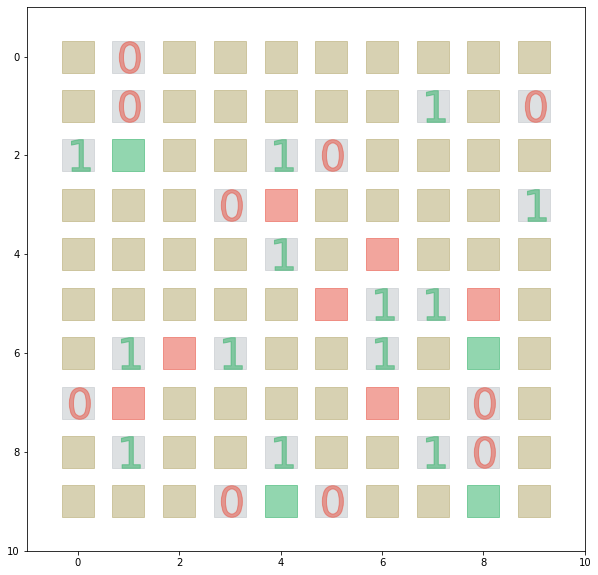

--textual
[[nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan],
 [nan, 0.0, nan, nan, nan, nan, nan, 1.0, nan, 0.0],
 [1.0, nan, nan, nan, 1.0, 0.0, nan, nan, nan, nan],
 [nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 1.0],
 [nan, nan, nan, nan, 1.0, nan, nan, nan, nan, nan],
 [nan, nan, nan, nan, nan, nan, 1.0, 1.0, nan, nan],
 [nan, 1.0, nan, 1.0, nan, nan, 1.0, nan, nan, nan],
 [0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, nan],
 [nan, 1.0, nan, nan, 1.0, nan, nan, 1.0, 0.0, nan],
 [nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan]]


@result:
--graphical


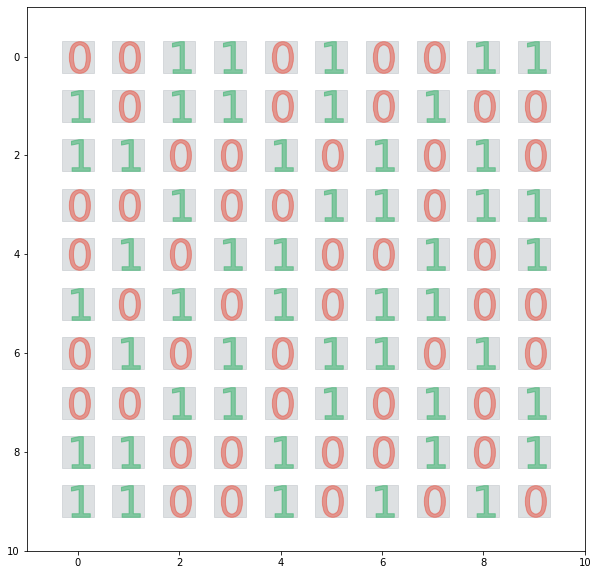

--textual
[[0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
 [1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
 [1, 1, 0, 0, 1, 0, 1, 0, 1, 0],
 [0, 0, 1, 0, 0, 1, 1, 0, 1, 1],
 [0, 1, 0, 1, 1, 0, 0, 1, 0, 1],
 [1, 0, 1, 0, 1, 0, 1, 1, 0, 0],
 [0, 1, 0, 1, 0, 1, 1, 0, 1, 0],
 [0, 0, 1, 1, 0, 1, 0, 1, 0, 1],
 [1, 1, 0, 0, 1, 0, 0, 1, 0, 1],
 [1, 1, 0, 0, 1, 0, 1, 0, 1, 0]]


#problem number 5 ------------------------
@successful: False
@elapsed time: 0.132 seconds
@start state:
--graphical


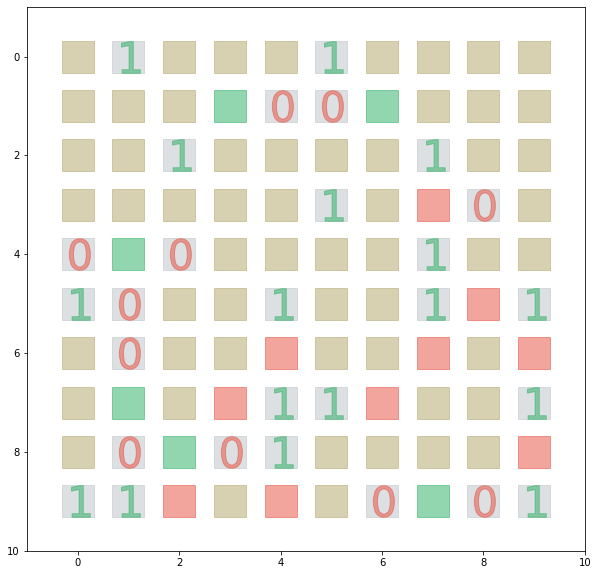

--textual
[[nan, 1.0, nan, nan, nan, 1.0, nan, nan, nan, nan],
 [nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan],
 [nan, nan, 1.0, nan, nan, nan, nan, 1.0, nan, nan],
 [nan, nan, nan, nan, nan, 1.0, nan, nan, 0.0, nan],
 [0.0, nan, 0.0, nan, nan, nan, nan, 1.0, nan, nan],
 [1.0, 0.0, nan, nan, 1.0, nan, nan, 1.0, nan, 1.0],
 [nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan],
 [nan, nan, nan, nan, 1.0, 1.0, nan, nan, nan, 1.0],
 [nan, 0.0, nan, 0.0, 1.0, nan, nan, nan, nan, nan],
 [1.0, 1.0, nan, nan, nan, nan, 0.0, nan, 0.0, 1.0]]


@result:
NO solution found...


In [9]:
report(configurations, results_FC, initial_FC)

In [76]:
initial_MAC = [] # after first updating domains
results_MAC = [] # final results
history_MAC = [] # history of each assignment in solving procedure
for index, config in enumerate(configurations):

    result = {}
    domains:    Dict[Tuple, List[int]] = config['domains']
    variables:  List[Tuple]            = config['variables']
    assignment: Dict[Tuple, int]       = config['assignment']
    
    s = len(config['map'])
    csp: CSP[Tuple, int] = CSP(variables, domains)

    csp.add_constraint(FirstConstraint(variables, s))
    csp.add_constraint(SecondConstraint(variables, s))
    csp.add_constraint(ThirdConstraint(variables, s))

    start = time.time()
    for a in assignment:
        domains = csp.MAC(domains, assignment, a)
    
    initial_MAC.append({
        'assignment': copy.deepcopy(assignment),
        'domains': copy.deepcopy(domains),
    })
    
    solution: Optional[Dict[Tuple, int]] = csp.backtracking_search_with_MAC(assignment=assignment, domains=domains)
    end = time.time()
    
    history_MAC.append(copy.deepcopy(csp.backtracking_MAC_history))
    if solution is None:
        print("No solution found!")
        result['final']      = None
        result['time']       = end - start
        result['successful'] = False
    else:
        print(f'elapsed time for problem {index}: {round(end - start, 5)}')
        mat = Matrix(s)
        mat.clear_populate(solution)
        m = mat.matrix
            
        assert np.where(np.isnan(m) == True)[0].size == 0 , "find np.nan in result!"
        assert np.where(np.isnan(m) == True)[1].size == 0 , "find np.nan in result!"

        result['final']      = m.astype(np.int8, copy=False)
        result['time']       = end - start
        result['successful'] = True
    
    results_MAC.append({
        'result': result,
        'domains': csp.domains
    })

elapsed time for problem 0: 0.02199
elapsed time for problem 1: 0.06896
elapsed time for problem 2: 0.10544
elapsed time for problem 3: 0.37395
elapsed time for problem 4: 126.10028
No solution found!


In [79]:
print(len(history_MAC[3]))

71


#problem number 0 ------------------------
@successful: True
@elapsed time: 0.022 seconds
@start state:
--graphical


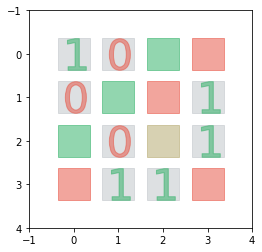

--textual
[[1.0, 0.0, nan, nan],
 [0.0, nan, nan, 1.0],
 [nan, 0.0, nan, 1.0],
 [nan, 1.0, 1.0, nan]]


@result:
--graphical


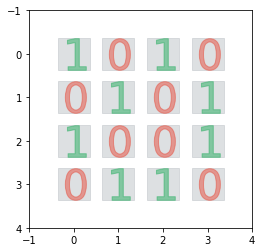

--textual
[[1, 0, 1, 0],
 [0, 1, 0, 1],
 [1, 0, 0, 1],
 [0, 1, 1, 0]]


#problem number 1 ------------------------
@successful: True
@elapsed time: 0.069 seconds
@start state:
--graphical


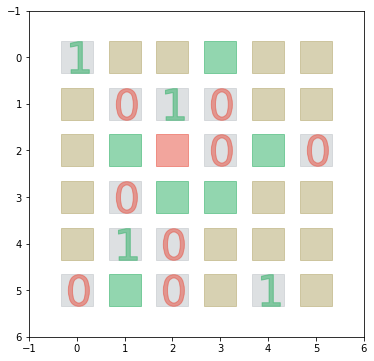

--textual
[[1.0, nan, nan, nan, nan, nan],
 [nan, 0.0, 1.0, 0.0, nan, nan],
 [nan, nan, nan, 0.0, nan, 0.0],
 [nan, 0.0, nan, nan, nan, nan],
 [nan, 1.0, 0.0, nan, nan, nan],
 [0.0, nan, 0.0, nan, 1.0, nan]]


@result:
--graphical


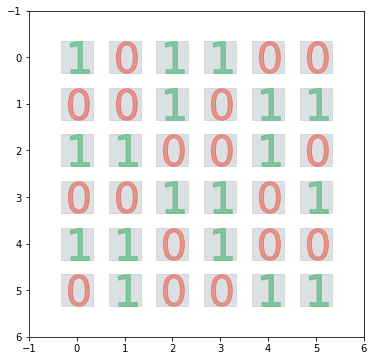

--textual
[[1, 0, 1, 1, 0, 0],
 [0, 0, 1, 0, 1, 1],
 [1, 1, 0, 0, 1, 0],
 [0, 0, 1, 1, 0, 1],
 [1, 1, 0, 1, 0, 0],
 [0, 1, 0, 0, 1, 1]]


#problem number 2 ------------------------
@successful: True
@elapsed time: 0.105 seconds
@start state:
--graphical


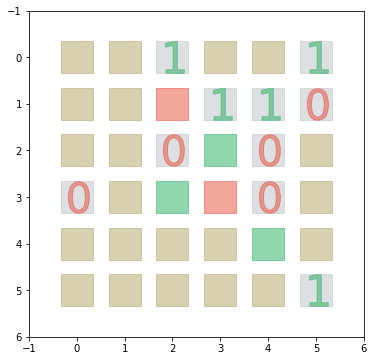

--textual
[[nan, nan, 1.0, nan, nan, 1.0],
 [nan, nan, nan, 1.0, 1.0, 0.0],
 [nan, nan, 0.0, nan, 0.0, nan],
 [0.0, nan, nan, nan, 0.0, nan],
 [nan, nan, nan, nan, nan, nan],
 [nan, nan, nan, nan, nan, 1.0]]


@result:
--graphical


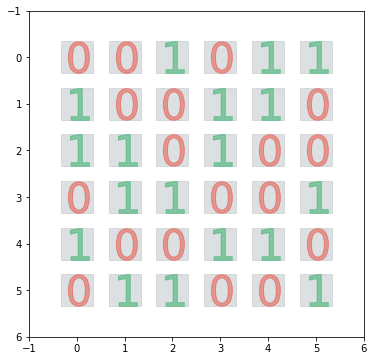

--textual
[[0, 0, 1, 0, 1, 1],
 [1, 0, 0, 1, 1, 0],
 [1, 1, 0, 1, 0, 0],
 [0, 1, 1, 0, 0, 1],
 [1, 0, 0, 1, 1, 0],
 [0, 1, 1, 0, 0, 1]]


#problem number 3 ------------------------
@successful: True
@elapsed time: 0.374 seconds
@start state:
--graphical


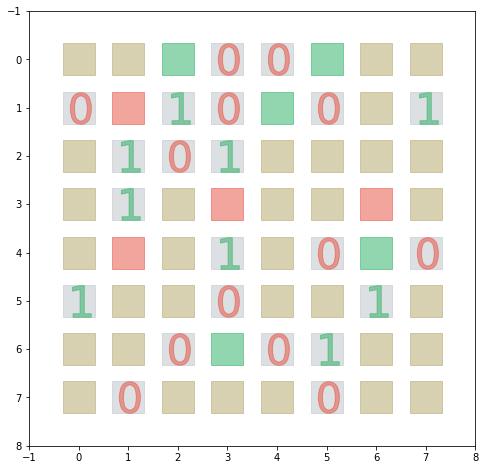

--textual
[[nan, nan, nan, 0.0, 0.0, nan, nan, nan],
 [0.0, nan, 1.0, 0.0, nan, 0.0, nan, 1.0],
 [nan, 1.0, 0.0, 1.0, nan, nan, nan, nan],
 [nan, 1.0, nan, nan, nan, nan, nan, nan],
 [nan, nan, nan, 1.0, nan, 0.0, nan, 0.0],
 [1.0, nan, nan, 0.0, nan, nan, 1.0, nan],
 [nan, nan, 0.0, nan, 0.0, 1.0, nan, nan],
 [nan, 0.0, nan, nan, nan, 0.0, nan, nan]]


@result:
--graphical


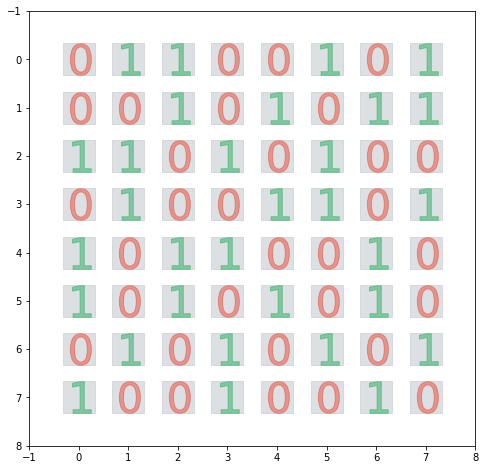

--textual
[[0, 1, 1, 0, 0, 1, 0, 1],
 [0, 0, 1, 0, 1, 0, 1, 1],
 [1, 1, 0, 1, 0, 1, 0, 0],
 [0, 1, 0, 0, 1, 1, 0, 1],
 [1, 0, 1, 1, 0, 0, 1, 0],
 [1, 0, 1, 0, 1, 0, 1, 0],
 [0, 1, 0, 1, 0, 1, 0, 1],
 [1, 0, 0, 1, 0, 0, 1, 0]]


#problem number 4 ------------------------
@successful: True
@elapsed time: 126.1 seconds
@start state:
--graphical


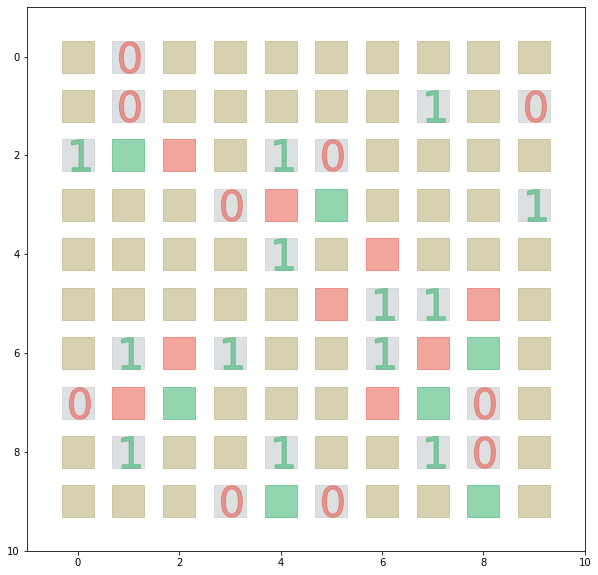

--textual
[[nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan],
 [nan, 0.0, nan, nan, nan, nan, nan, 1.0, nan, 0.0],
 [1.0, nan, nan, nan, 1.0, 0.0, nan, nan, nan, nan],
 [nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 1.0],
 [nan, nan, nan, nan, 1.0, nan, nan, nan, nan, nan],
 [nan, nan, nan, nan, nan, nan, 1.0, 1.0, nan, nan],
 [nan, 1.0, nan, 1.0, nan, nan, 1.0, nan, nan, nan],
 [0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, nan],
 [nan, 1.0, nan, nan, 1.0, nan, nan, 1.0, 0.0, nan],
 [nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan]]


@result:
--graphical


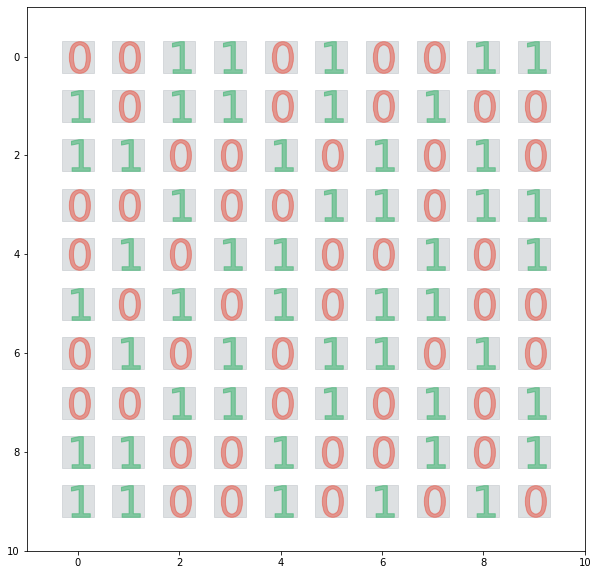

--textual
[[0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
 [1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
 [1, 1, 0, 0, 1, 0, 1, 0, 1, 0],
 [0, 0, 1, 0, 0, 1, 1, 0, 1, 1],
 [0, 1, 0, 1, 1, 0, 0, 1, 0, 1],
 [1, 0, 1, 0, 1, 0, 1, 1, 0, 0],
 [0, 1, 0, 1, 0, 1, 1, 0, 1, 0],
 [0, 0, 1, 1, 0, 1, 0, 1, 0, 1],
 [1, 1, 0, 0, 1, 0, 0, 1, 0, 1],
 [1, 1, 0, 0, 1, 0, 1, 0, 1, 0]]


#problem number 5 ------------------------
@successful: False
@elapsed time: 0.254 seconds
@start state:
--graphical


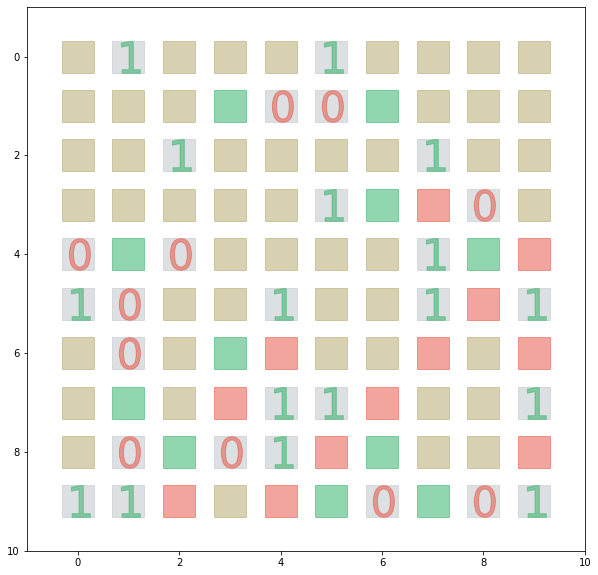

--textual
[[nan, 1.0, nan, nan, nan, 1.0, nan, nan, nan, nan],
 [nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan],
 [nan, nan, 1.0, nan, nan, nan, nan, 1.0, nan, nan],
 [nan, nan, nan, nan, nan, 1.0, nan, nan, 0.0, nan],
 [0.0, nan, 0.0, nan, nan, nan, nan, 1.0, nan, nan],
 [1.0, 0.0, nan, nan, 1.0, nan, nan, 1.0, nan, 1.0],
 [nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan],
 [nan, nan, nan, nan, 1.0, 1.0, nan, nan, nan, 1.0],
 [nan, 0.0, nan, 0.0, 1.0, nan, nan, nan, nan, nan],
 [1.0, 1.0, nan, nan, nan, nan, 0.0, nan, 0.0, 1.0]]


@result:
NO solution found...


In [80]:
report(configurations, results_MAC, initial_MAC)

In [23]:
export_images(history_, '../images/vanilla')

exporting images in ../images/vanilla
exporting images for problem 0 ,elapsed time: 0.8939003944396973, images: 15
exporting images for problem 1 ,elapsed time: 12.247435808181763, images: 174
exporting images for problem 2 ,elapsed time: 11.718579053878784, images: 199
exporting images for problem 3 ,elapsed time: 17.169917345046997, images: 235
exporting images for problem 4, too many images [144542] => aborted


In [24]:
export_images(history_FC, '../images/FC')

exporting images in ../images/FC
exporting images for problem 0 ,elapsed time: 4.487626075744629, images: 8
exporting images for problem 1 ,elapsed time: 1.4785852432250977, images: 25
exporting images for problem 2 ,elapsed time: 2.188042640686035, images: 37
exporting images for problem 3 ,elapsed time: 5.406130075454712, images: 74
exporting images for problem 4 ,elapsed time: 599.7265660762787, images: 7609
exporting images for problem 5 ,elapsed time: 2.176445484161377, images: 26


In [86]:
export_images(history_MAC, '../images/MAC')

exporting images in ../images/MAC
exporting images for problem 0 ,elapsed time: 0.4329416751861572, images: 8
exporting images for problem 1 ,elapsed time: 1.5482161045074463, images: 25
exporting images for problem 2 ,elapsed time: 2.824388265609741, images: 37
exporting images for problem 3 ,elapsed time: 5.516138076782227, images: 71
exporting images for problem 4 ,elapsed time: 628.0788354873657, images: 7415
exporting images for problem 5 ,elapsed time: 2.2787623405456543, images: 26


In [46]:
frame_rates = []
for index, history in enumerate(history_):
    if len(history) < 10:
        frame_rates.append(1)
    elif 10 <= len(history) < 1000 :
        frame_rates.append(5)
    elif 1000 <= len(history):
        frame_rates.append(15)
        
make_animation(frame_rates, 'vanilla')

making animation for problem 0
making animation for problem 1
making animation for problem 2
making animation for problem 3
making animation for problem 4


In [47]:
frame_rates = []
for index, history in enumerate(history_FC):
    if len(history) < 10:
        frame_rates.append(1)
    elif 10 <= len(history) < 1000 :
        frame_rates.append(5)
    elif 1000 <= len(history):
        frame_rates.append(15)
        
make_animation(frame_rates, 'FC')

making animation for problem 0
making animation for problem 1
making animation for problem 2
making animation for problem 3
making animation for problem 4
making animation for problem 5


In [87]:
frame_rates = []
for index, history in enumerate(history_MAC):
    if len(history) < 10:
        frame_rates.append(1)
    elif 10 <= len(history) < 1000 :
        frame_rates.append(5)
    elif 1000 <= len(history):
        frame_rates.append(15)
        
make_animation(frame_rates, 'MAC')

making animation for problem 0
making animation for problem 1
making animation for problem 2
making animation for problem 3
making animation for problem 4
making animation for problem 5


## Conclusion
### as we see in FC we have less computation time (especially on problem 4) but in MAC we have less wrong assignments. (the amount of this differences, heavily depends on the type of problem)

In [145]:
# headers = ['', 'simple BT', 'BT with FC', 'BT with MAC']
headers = ['', 'time', 'assignments', 'successful']
records = []
records_ = []
records_FC = []
records_MAC = []
import tabulate

for index, config in enumerate(configurations[:-1]):
    records_.append((f'. puzzle {index}',
                     f"{round(results_[index]['result']['time'], 4):.4f}",
                     len(history_[index]),
                     results_[index]['result']['successful']))
records_.append((f'# puzzle {index + 1}', f'very long!', 'many!', False))

for index, config in enumerate(configurations):
    records_FC.append((f'. puzzle {index}',
                     f"{round(results_FC[index]['result']['time'], 4):.4f}",
                     len(history_FC[index]),
                     results_FC[index]['result']['successful']))


for index, config in enumerate(configurations):
    records_MAC.append((f'. puzzle {index}',
                     f"{round(results_MAC[index]['result']['time'], 4):.4f}",
                     len(history_MAC[index]),
                     results_MAC[index]['result']['successful']))

records.append(('# simple BT', None, None, None))
records.extend(records_)
records.append(('# BT with FC', None, None, None))
records.extend(records_FC)
records.append(('# BT with MAC', None, None, None))
records.extend(records_MAC)


print(tabulate.tabulate(records, headers=headers, tablefmt='psql'))

+---------------+------------+---------------+--------------+
|               | time       | assignments   | successful   |
|---------------+------------+---------------+--------------|
| # simple BT   |            |               |              |
| . puzzle 0    | 0.0060     | 15            | True         |
| . puzzle 1    | 0.0960     | 174           | True         |
| . puzzle 2    | 0.1090     | 199           | True         |
| . puzzle 3    | 0.2311     | 235           | True         |
| . puzzle 4    | 221.5299   | 144542        | True         |
| # puzzle 5    | very long! | many!         | False        |
| # BT with FC  |            |               |              |
| . puzzle 0    | 0.0061     | 8             | True         |
| . puzzle 1    | 0.0400     | 25            | True         |
| . puzzle 2    | 0.0570     | 37            | True         |
| . puzzle 3    | 0.2030     | 74            | True         |
| . puzzle 4    | 29.0645    | 7609          | True         |
| . puzz